# SETUP

In [1]:
# !pip install yfinance --upgrade --no-cache-dir
# !pip install git+https://github.com/quantopian/pyfolio
# !pip install alpha_vantage
# !pip install requests==2.31.0
# !pip install arch 

In [50]:
#Análise de Dados e Gráfica

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Financeira

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')


#Tratamento Dados

from datetime import datetime, date, timedelta

#Testes estatísticos

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelos

from arch.univariate import GARCH

# EXTRAÇÃO DOS DADOS

## PREÇOS DAS AÇÕES

In [3]:
Petr4 = web.get_data_yahoo(['PETR4.SA'])[['Open','Close']].reset_index()
Prio3 = web.get_data_yahoo(['PRIO3.SA'])[['Open','Close']].reset_index()
Brent = web.get_data_yahoo(['BZ=F'])[['Open','Close']].reset_index()
WTI = web.get_data_yahoo(['CL=F'])[['Open','Close']].reset_index()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
Prio3 = Prio3[(Prio3['Date'] >= '2021-01-01') & (Prio3['Date'] <= '2024-03-31')].reset_index(drop=True)
Petr4 = Petr4[(Petr4['Date'] >= '2021-01-01') & (Petr4['Date'] <= '2024-03-31')].reset_index(drop=True)
Brent = Brent[(Brent['Date'] >= '2021-01-01') & (Brent['Date'] <= '2024-03-31')].reset_index(drop=True)
WTI = WTI[(WTI['Date'] >= '2021-01-01') & (WTI['Date'] <= '2024-03-31')].reset_index(drop=True)


In [5]:
WTI

,Date,Open,Close
0,2021-01-04,48.400002,47.619999
1,2021-01-05,47.380001,49.930000
2,2021-01-06,49.820000,50.630001
3,2021-01-07,50.529999,50.830002
4,2021-01-08,50.930000,52.240002
...,...,...,...
810,2024-03-22,80.839996,80.629997
811,2024-03-25,80.849998,81.949997
812,2024-03-26,81.940002,81.620003
813,2024-03-27,81.290001,81.349998


## Feature Engineering

In [6]:
balancos_petr4 = {'balancos_petr4': ['2021-05-13','2021-07-29','2021-10-29','2022-02-23','2022-05-05','2022-07-28','2022-11-03','2023-03-01','2023-05-12','2023-08-04','2023-11-10','2024-03-08']}
balancos_prio3 = {'balancos_prio3': ['2021-05-03','2021-08-03','2021-11-03','2022-02-15','2022-05-02','2022-08-01','2022-10-31','2023-03-01','2023-05-04','2023-08-03','2023-11-01','2024-03-14']}
balancos_petr4_dt = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in balancos_petr4['balancos_petr4']]
balancos_prio3_dt = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in balancos_prio3['balancos_prio3']]


#Petr4

for index, row in Petr4.iterrows():
    date_df = datetime.strptime(row['Date'].strftime('%Y-%m-%d'), '%Y-%m-%d')
    if date_df in balancos_petr4_dt:
        Petr4.loc[index -1, 'Divulgacao'] = 'Dia_Anterior_Divulgacao'
        Petr4.loc[index, 'Divulgacao'] = 'Dia_Divulgacao'
        Petr4.loc[index +1, 'Divulgacao'] = 'Dia_Posterior_Divulgacao'

Petr4['Divulgacao'].fillna('Sem_Divulgacao', inplace=True)

#Prio3

for index, row in Prio3.iterrows():
    date_df = datetime.strptime(row['Date'].strftime('%Y-%m-%d'), '%Y-%m-%d')
    if date_df in balancos_prio3_dt:
        Prio3.loc[index -1, 'Divulgacao'] = 'Dia_Anterior_Divulgacao'
        Prio3.loc[index, 'Divulgacao'] = 'Dia_Divulgacao'
        Prio3.loc[index +1, 'Divulgacao'] = 'Dia_Posterior_Divulgacao'

Prio3['Divulgacao'].fillna('Sem_Divulgacao', inplace=True)
    

In [7]:
# Calcular Variação de preço da ação

#Petr4

Petr4['Variacao_Abertura'] = Petr4['Open'] - Petr4['Open'].shift(1)
Petr4['Variacao_Fechamento'] = Petr4['Close'] - Petr4['Close'].shift(1)
Petr4['Amplitude'] = Petr4['Close'] - Petr4['Open']
Petr4['Variancia'] = Petr4[['Open', 'Close']].var(axis=1)
Petr4['log'] = np.log(Petr4['Close'])
Petr4['Fechamento_Anterior'] = Petr4['Close'].shift(1)
Petr4['Retorno'] = Petr4['log'] / Petr4['Fechamento_Anterior']
Petr4 = Petr4.drop(columns=['log','Fechamento_Anterior'])

Petr4['Nome_Papel'] = 'Petr4'

for index, row in Petr4.iterrows():
    data_atual = row['Date']
    divulgacao = row['Divulgacao']
    if 'Dia_Divulgacao' in divulgacao:
        Petr4.at[index, 'Ate_Divulgacao'] = 0
    else:
        proxima_divulgacao = None
        for prox_index, prox_row in Petr4.iloc[index+1:].iterrows():
            if 'Dia_Divulgacao' in prox_row['Divulgacao']:
                proxima_divulgacao = prox_row['Date']
                break
        if proxima_divulgacao is None:
            dias_restantes = (data_atual - datetime.now()).days
        else:
            dias_restantes = (proxima_divulgacao - data_atual).days
        Petr4.at[index, 'Ate_Divulgacao'] = dias_restantes


#Prio3

Prio3['Variacao_Abertura'] = Prio3['Open'] - Prio3['Open'].shift(1)
Prio3['Variacao_Fechamento'] = Prio3['Close'] - Prio3['Close'].shift(1)
Prio3['Amplitude'] = Prio3['Close'] - Prio3['Open']
Prio3['Nome_Papel'] = 'Prio3'
Prio3['Variancia'] = Prio3[['Open', 'Close']].var(axis=1)
Prio3['log'] = np.log(Prio3['Close'])
Prio3['Fechamento_Anterior'] = Prio3['Close'].shift(1)
Prio3['Retorno'] = Prio3['log'] / Prio3['Fechamento_Anterior']
Prio3 = Prio3.drop(columns=['log','Fechamento_Anterior'])

for index, row in Prio3.iterrows():
    data_atual = row['Date']
    divulgacao = row['Divulgacao']
    if 'Dia_Divulgacao' in divulgacao:
        Prio3.at[index, 'Ate_Divulgacao'] = 0
    else:
        proxima_divulgacao = None
        for prox_index, prox_row in Prio3.iloc[index+1:].iterrows():
            if 'Dia_Divulgacao' in prox_row['Divulgacao']:
                proxima_divulgacao = prox_row['Date']
                break
        if proxima_divulgacao is None:
            dias_restantes = (data_atual - datetime.now()).days
        else:
            dias_restantes = (proxima_divulgacao - data_atual).days
        Prio3.at[index, 'Ate_Divulgacao'] = dias_restantes


Prio3 = Prio3.drop(Prio3[Prio3['Ate_Divulgacao'] < 0].index)
Petr4 = Petr4.drop(Petr4[Petr4['Ate_Divulgacao'] < 0].index)

#Brent

Brent['Variacao_Abertura'] = Brent['Open'] - Brent['Open'].shift(1)
Brent['Variacao_Fechamento'] = Brent['Close'] - Brent['Close'].shift(1)
Brent['Amplitude'] = Brent['Close'] - Brent['Open']
Brent['Variancia'] = Brent[['Open', 'Close']].var(axis=1)
Brent['log'] = np.log(Brent['Close'])
Brent['Fechamento_Anterior'] = Brent['Close'].shift(1)
Brent['Retorno'] = Brent['log'] / Brent['Fechamento_Anterior']
Brent = Brent.drop(columns=['log','Fechamento_Anterior'])

#WTI

WTI['Variacao_Abertura'] = WTI['Open'] - WTI['Open'].shift(1)
WTI['Variacao_Fechamento'] = WTI['Close'] - WTI['Close'].shift(1)
WTI['Amplitude'] = WTI['Close'] - WTI['Open']
WTI['Variancia'] = WTI[['Open', 'Close']].var(axis=1)
WTI['log'] = np.log(WTI['Close'])
WTI['Fechamento_Anterior'] = WTI['Close'].shift(1)
WTI['Retorno'] = WTI['log'] / WTI['Fechamento_Anterior']
WTI = WTI.drop(columns=['log','Fechamento_Anterior'])

In [8]:
df = pd.concat([Petr4,Prio3]).sort_values(by=['Date','Nome_Papel']).reset_index(drop=True)

# ANOVA

## Teste 1

### Hipóteses
  H0 = Não existe diferença de variação da amplitude das ações em relação a Divulgação e Ação

  H1 = Existem diferenças significativas de variação da amplitude das ações em relação a Divulgação e Ação

In [10]:
teste_anova1 = df[['Amplitude','Divulgacao','Nome_Papel']]

In [11]:
teste_anova1.Divulgacao.unique()

array(['Sem_Divulgacao', 'Dia_Anterior_Divulgacao', 'Dia_Divulgacao',
       'Dia_Posterior_Divulgacao'], dtype=object)

(array([1, 2, 3, 4]),
 [Text(1, 0, 'Dia_Anterior_Divulgacao'),
  Text(2, 0, 'Dia_Divulgacao'),
  Text(3, 0, 'Dia_Posterior_Divulgacao'),
  Text(4, 0, 'Sem_Divulgacao')])

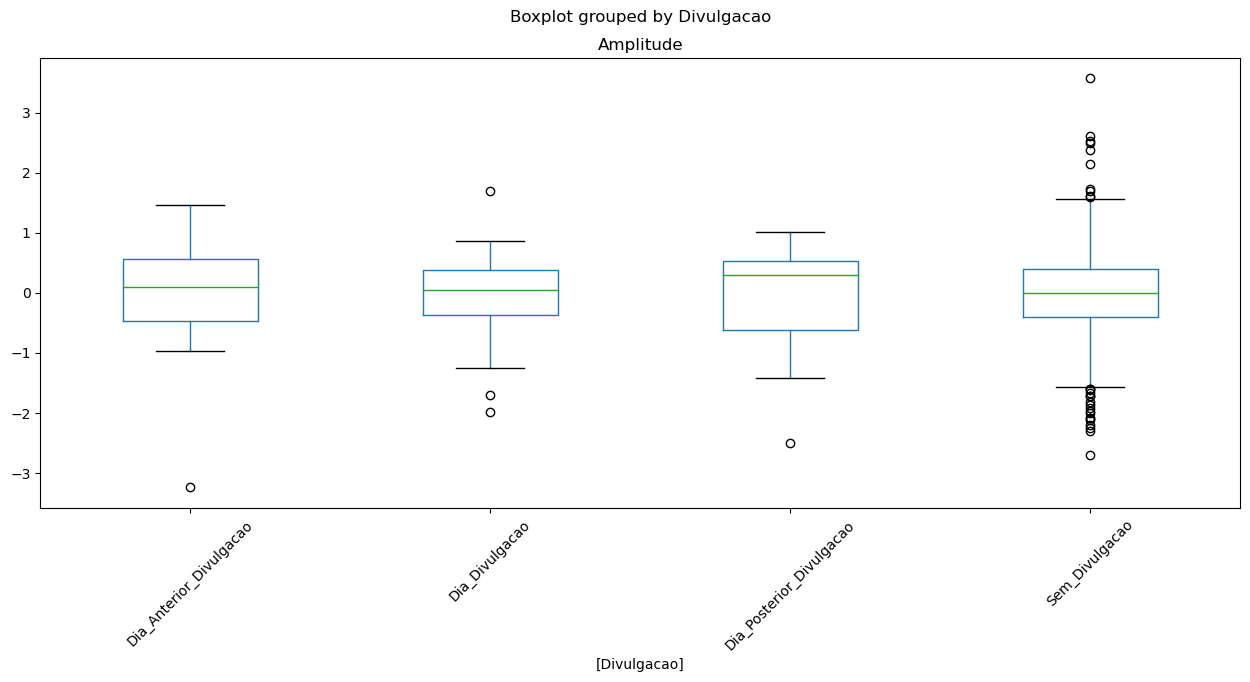

In [12]:
ax = teste_anova1.boxplot(by='Divulgacao', grid = False,figsize=(15,6))
plt.xticks(rotation=45)

In [13]:
modelo1 = ols('Amplitude ~ Divulgacao * Nome_Papel', data = teste_anova1).fit()
resultado1 = sm.stats.anova_lm(modelo1)
resultado1

,df,sum_sq,mean_sq,F,PR(>F)
Divulgacao,3.0,0.291295,0.097098,0.219262,0.883069
Nome_Papel,1.0,0.678764,0.678764,1.532743,0.215885
Divulgacao:Nome_Papel,3.0,0.661369,0.220456,0.497821,0.683834
Residual,1580.0,699.691147,0.442842,NaN,NaN


O Pvalor ficou acima do nível de significância em todos os testes, o que indica que não existe evidência estatística suficiente para rejeição de H0



## Teste 2

 ### Hipóteses

  H0 = Não existe diferença de variação da amplitude das ações em relação ao dia até a divulgação

  H1 = Existem diferenças de variação da amplitude das ações em relação ao dia até a divulgação

In [14]:
teste_anova2 = df[['Amplitude','Ate_Divulgacao','Nome_Papel']]
teste_anova2.loc[teste_anova2['Ate_Divulgacao'] < 0, 'Ate_Divulgacao'] = pd.NA
teste_anova2 = teste_anova2.dropna(subset=['Ate_Divulgacao'])


modelo2 = ols('Amplitude ~ Ate_Divulgacao * Nome_Papel', data = teste_anova2).fit()
resultado2 = sm.stats.anova_lm(modelo2)
resultado2

,df,sum_sq,mean_sq,F,PR(>F)
Nome_Papel,1.0,0.678568,0.678568,1.535183,0.215520
Ate_Divulgacao,1.0,0.435641,0.435641,0.985588,0.320975
Ate_Divulgacao:Nome_Papel,1.0,0.062554,0.062554,0.141521,0.706824
Residual,1584.0,700.145812,0.442011,NaN,NaN


Da mesma maneira que o teste anterior o Pvalor ficou alto, apontando que não existe evidência estatística o suficiente para rejeitar H0

## Teste 3 - Realizando um teste para cara papel

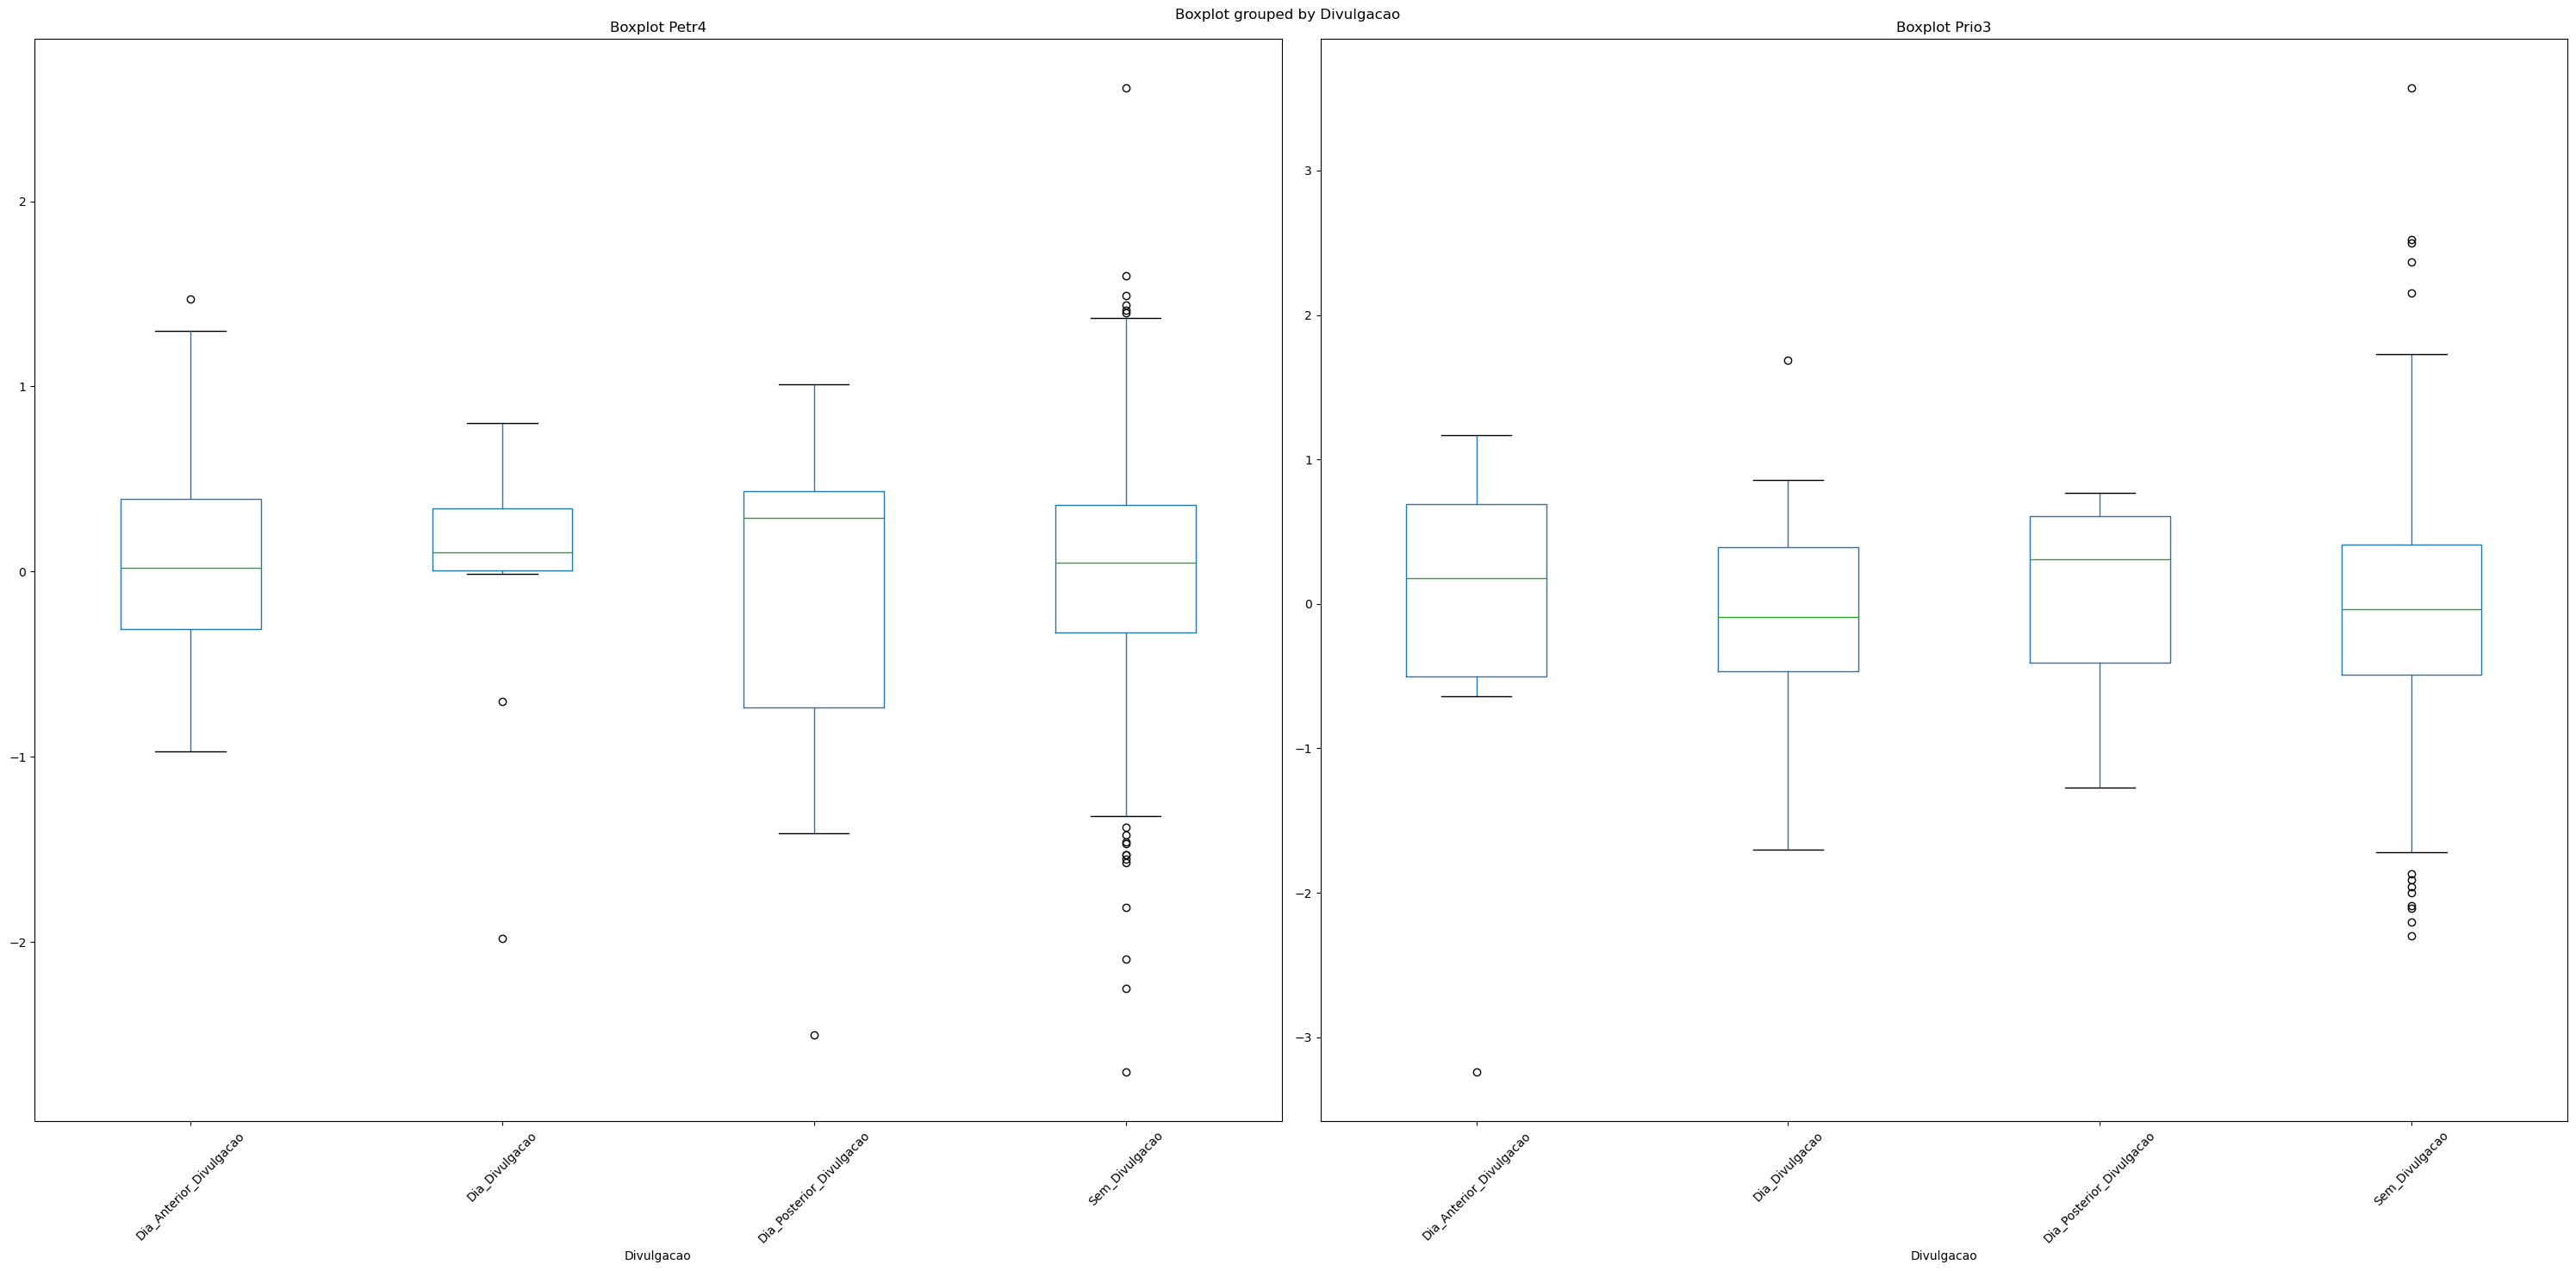

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
Petr4.boxplot(by='Divulgacao',column='Amplitude', grid=False, ax=ax1)
ax1.set_title('Boxplot Petr4')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
Prio3.boxplot(by='Divulgacao',column='Amplitude', grid=False, ax=ax2)
ax2.set_title('Boxplot Prio3')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Petr4

modelo3_petr4 = ols('Amplitude ~ Divulgacao', data = Petr4).fit()
resultado_petra = sm.stats.anova_lm(modelo3_petr4)
resultado_petra



,df,sum_sq,mean_sq,F,PR(>F)
Divulgacao,3.0,0.875268,0.291756,0.841417,0.471362
Residual,788.0,273.234079,0.346744,NaN,NaN


In [17]:
# Prio3

modelo3_prio3 = ols('Amplitude ~ Divulgacao', data = Prio3).fit()
resultado_prio = sm.stats.anova_lm(modelo3_prio3)
resultado_prio

,df,sum_sq,mean_sq,F,PR(>F)
Divulgacao,3.0,0.077592,0.025864,0.048034,0.986054
Residual,792.0,426.457069,0.538456,NaN,NaN


# Series Temporais

Ao realizar o ANOVA não foi possível encontrar envidência estatística de que existe diferenças nos dias de divulgação do balanço. Porém via análise gráfica (blox-plot) foi possível notar que em dias que não tem divulgação existe uma variabilidade maior na amplitude dos preços das ações. Por isso será trabalhado um modelo de série temporal para que seja possível prever essa variação em relação ao tempo.

In [18]:
df.set_index('Date', drop= True, inplace=True)
Brent.set_index('Date', drop=True, inplace=True)
WTI.set_index('Date', drop=True, inplace=True)

In [19]:
petr4 = df[df['Nome_Papel'] != 'Petr4']
prio3 = df[df['Nome_Papel'] != 'Prio3']
divulgacoes_petr4 = df[(df['Divulgacao'] != 'Sem_Divulgacao') & (df['Nome_Papel'] != 'Petr4')]
divulgacoes_prio3 = df[(df['Divulgacao'] != 'Sem_Divulgacao') & (df['Nome_Papel'] != 'Prio3')]

## Amplitude

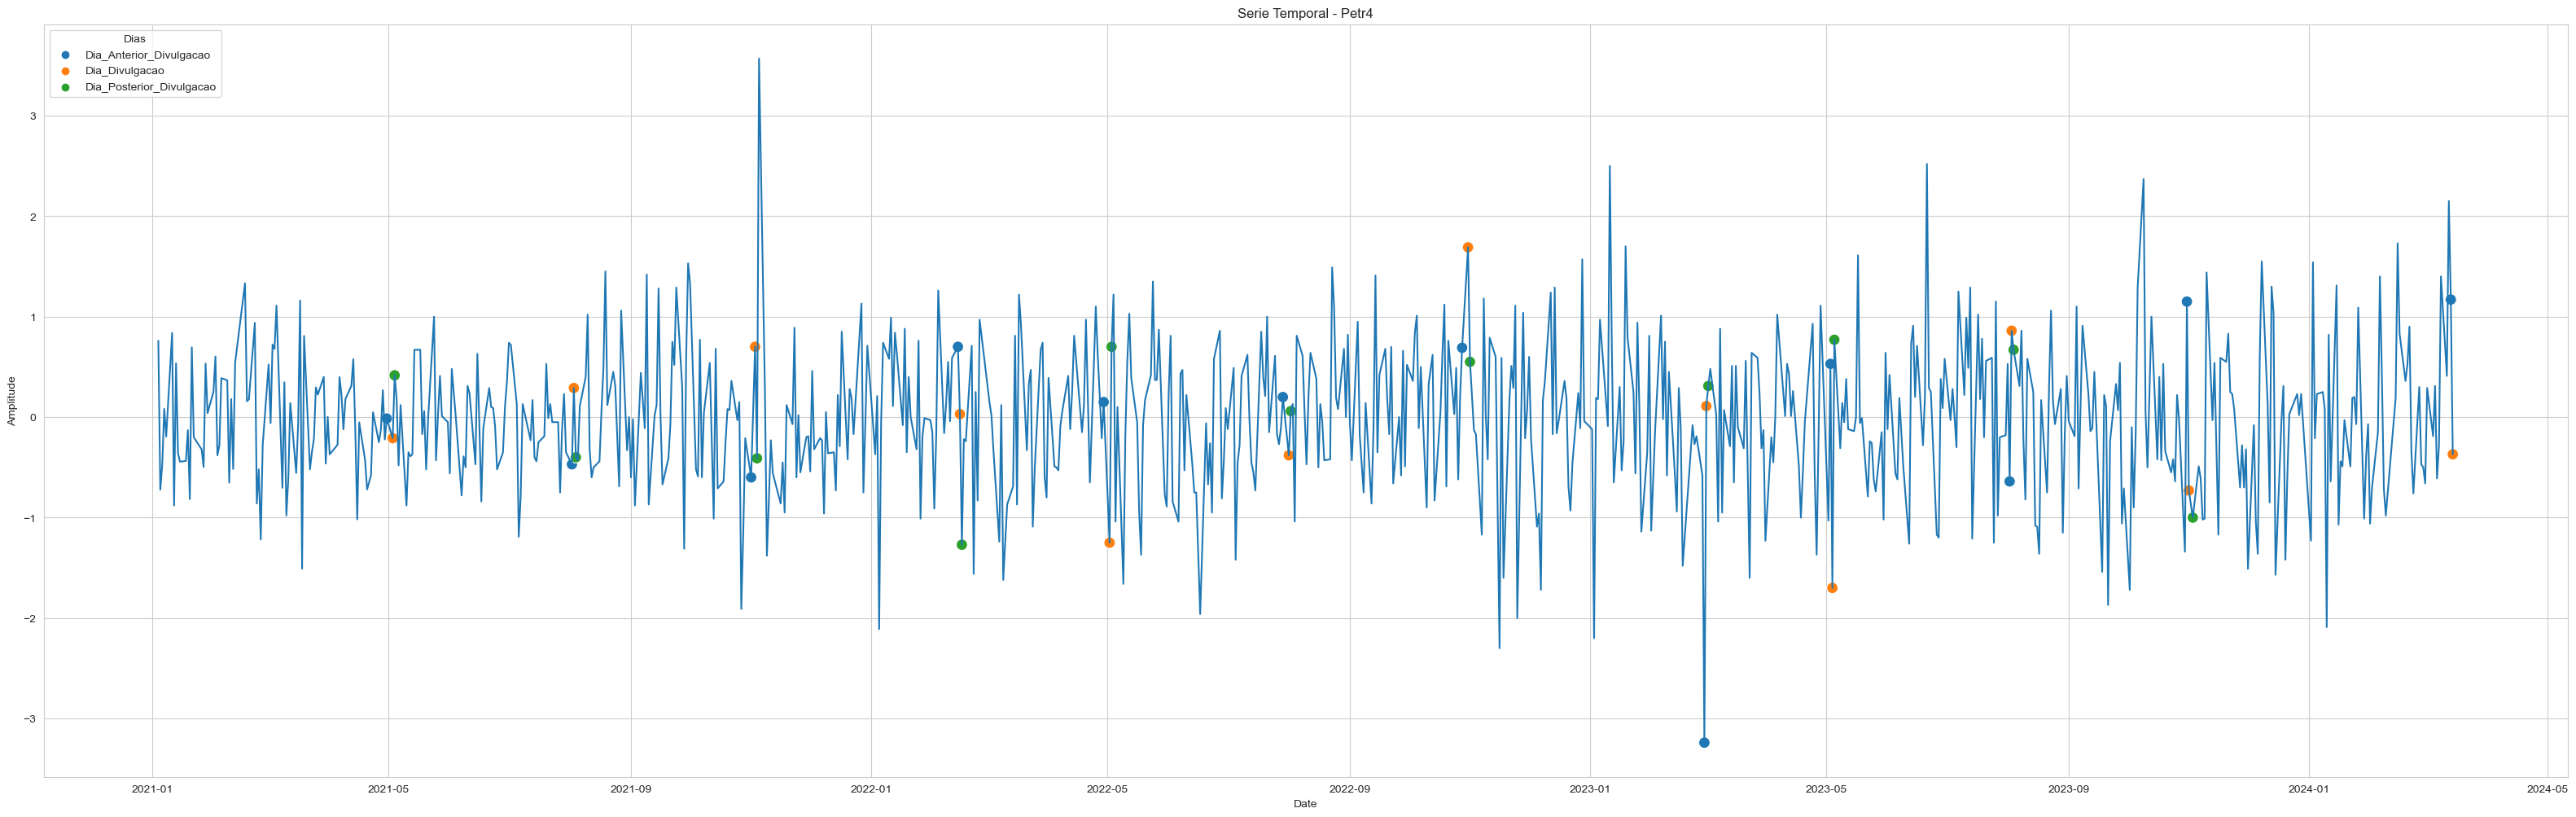

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=petr4.index, y='Amplitude', data=petr4, palette='tab10')
sns.scatterplot(x=divulgacoes_petr4.index, y='Amplitude', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Petr4')
plt.legend(title='Dias', loc='upper left')
plt.show()

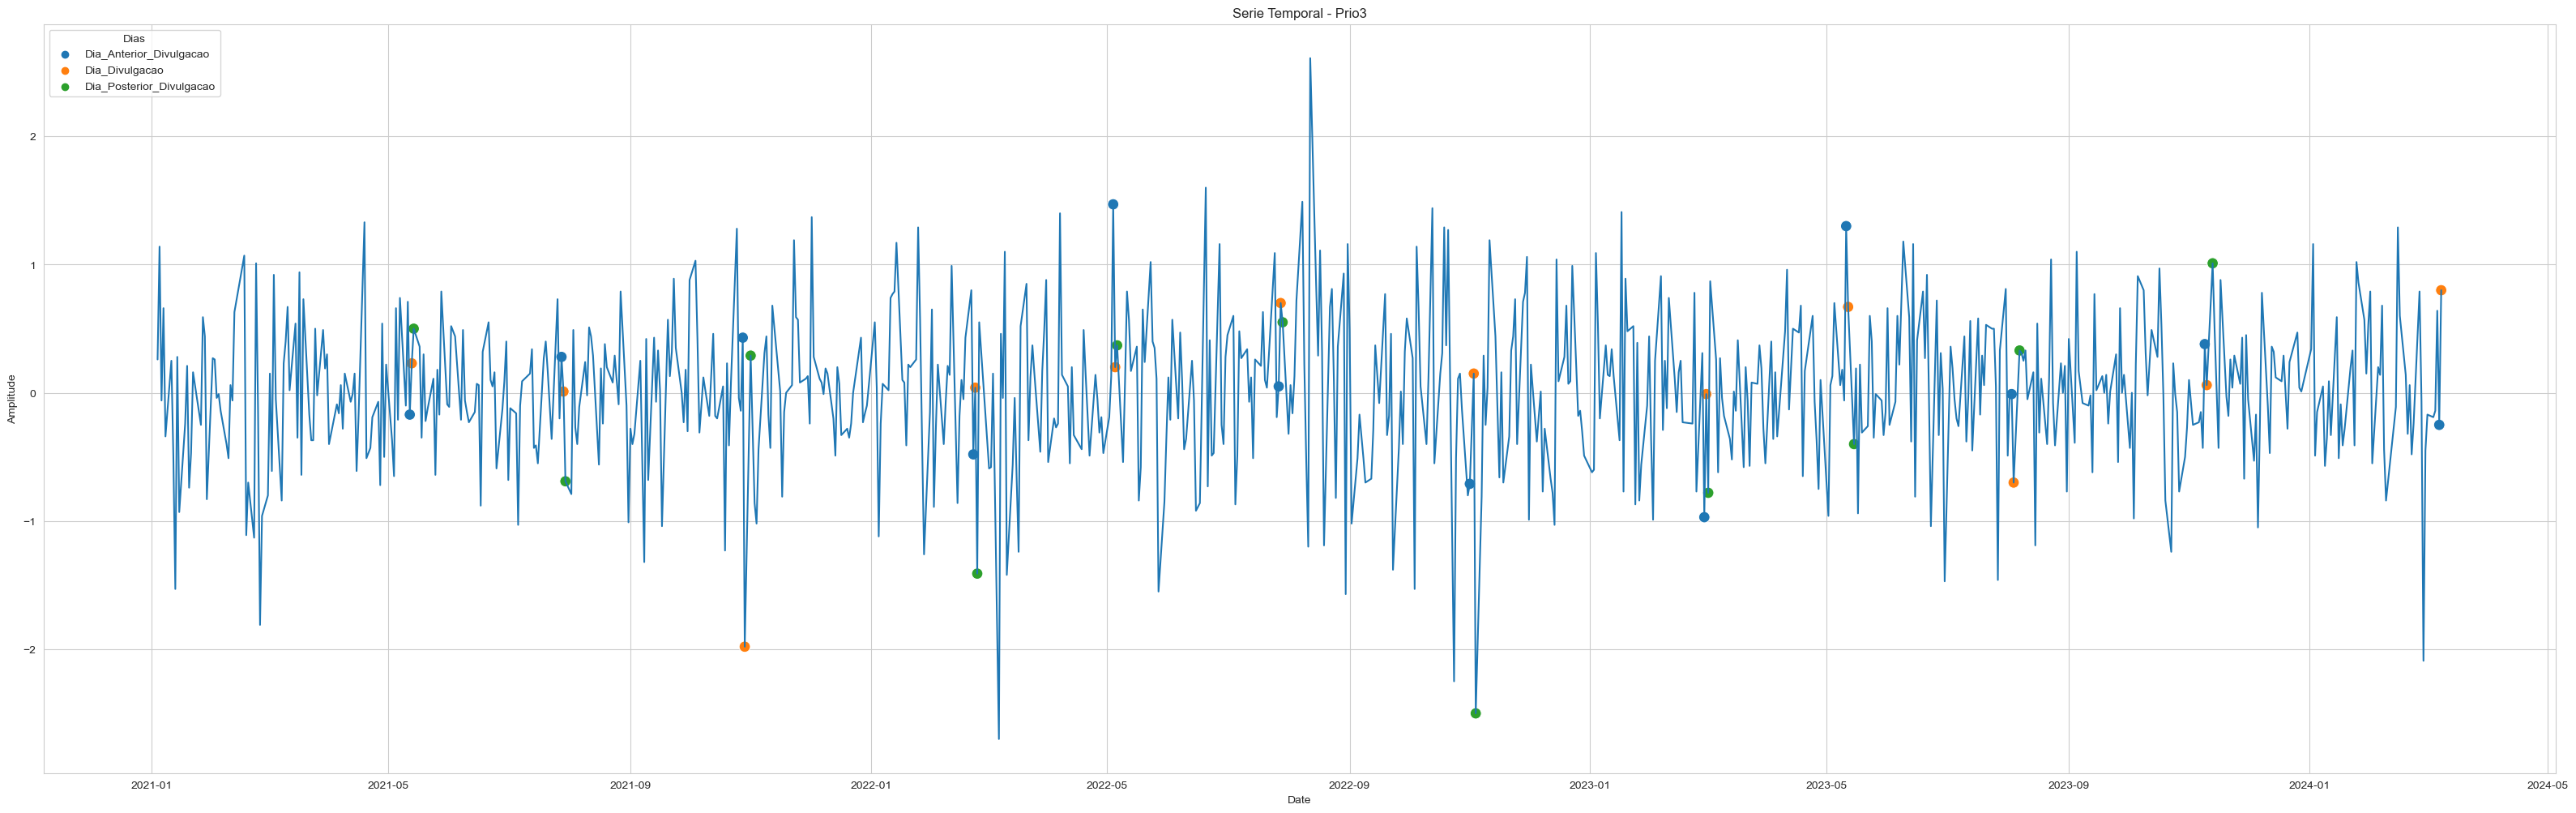

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=prio3.index, y='Amplitude', data=prio3, palette='tab10')
sns.scatterplot(x=divulgacoes_prio3.index, y='Amplitude', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Prio3')
plt.legend(title='Dias', loc='upper left')
plt.show()

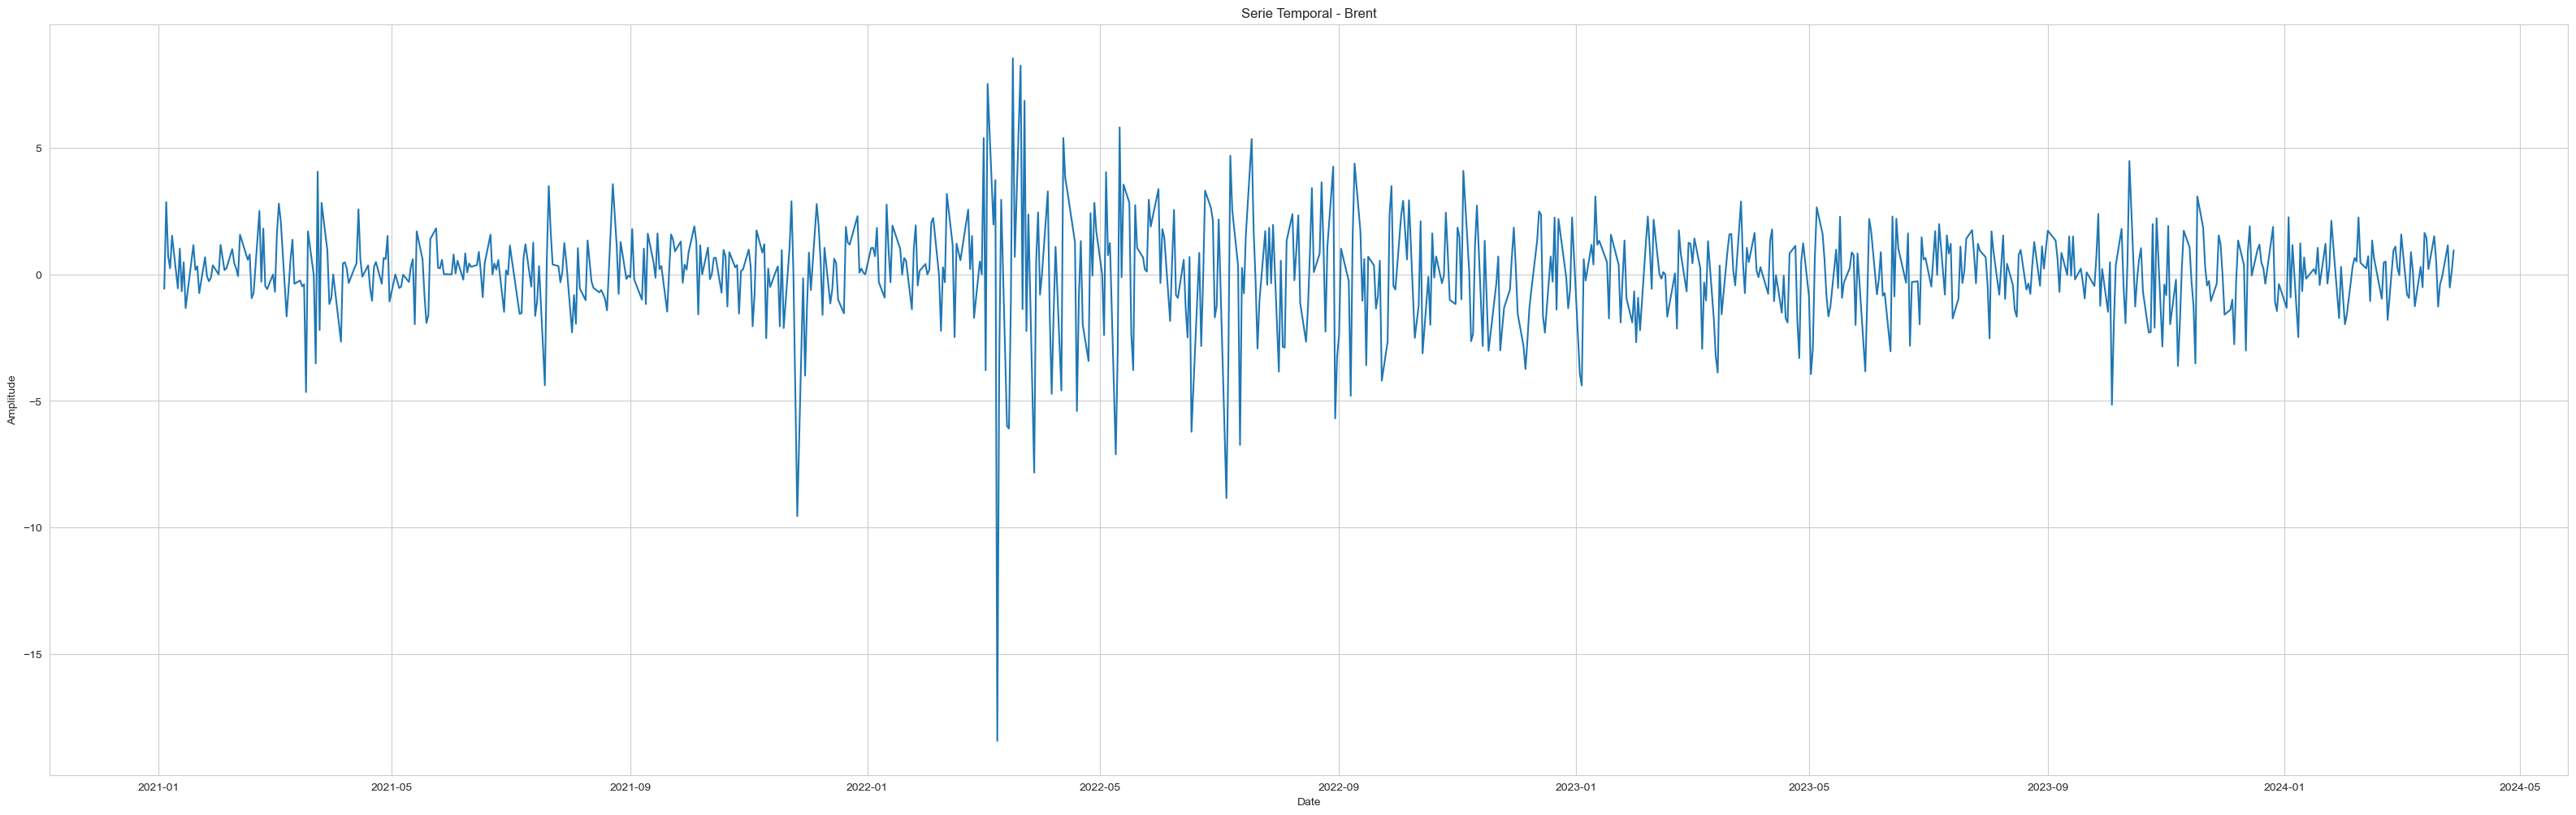

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=Brent.index, y='Amplitude', data=Brent, palette='tab10')
plt.title('Serie Temporal - Brent')
plt.show()

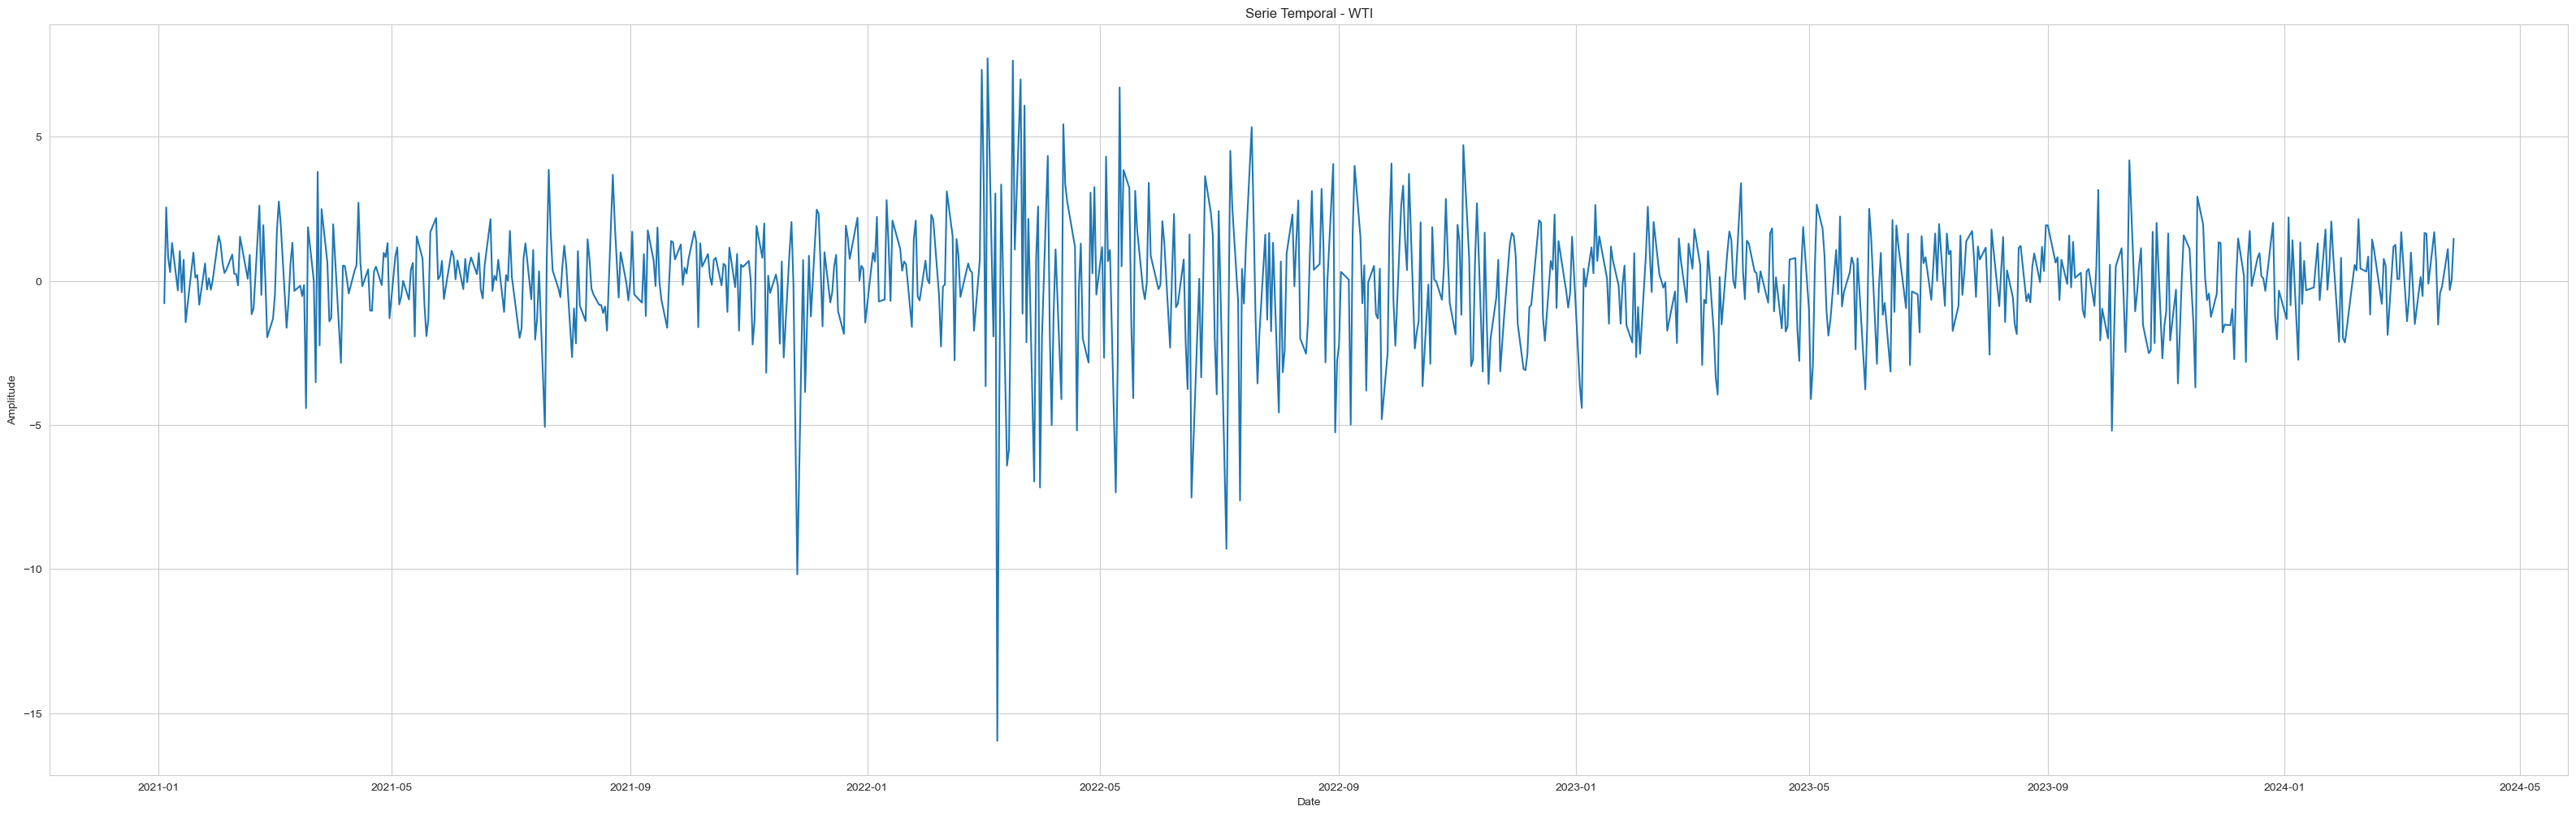

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=WTI.index, y='Amplitude', data=WTI, palette='tab10')
plt.title('Serie Temporal - WTI')
plt.show()

## Variancia

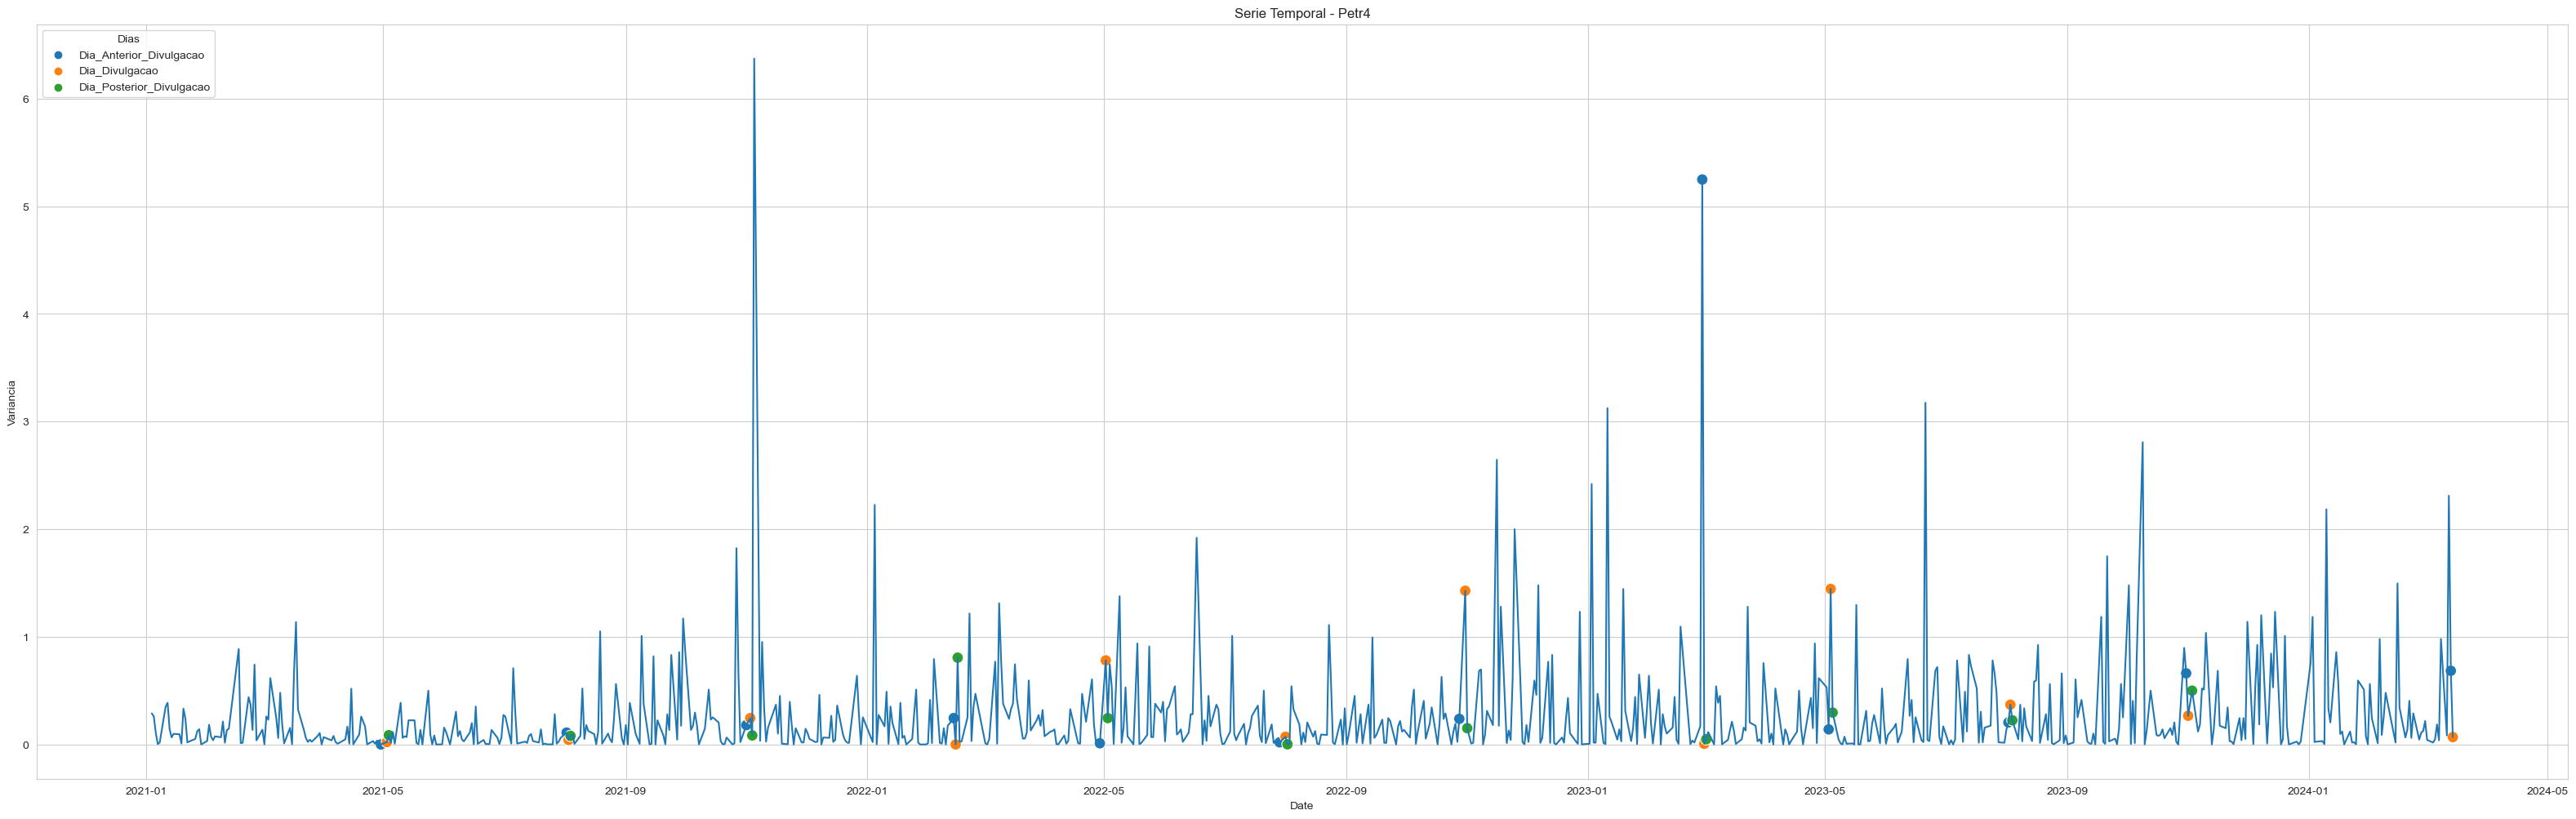

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=petr4.index, y='Variancia', data=petr4, palette='tab10')
sns.scatterplot(x=divulgacoes_petr4.index, y='Variancia', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Petr4')
plt.legend(title='Dias', loc='upper left')
plt.show()

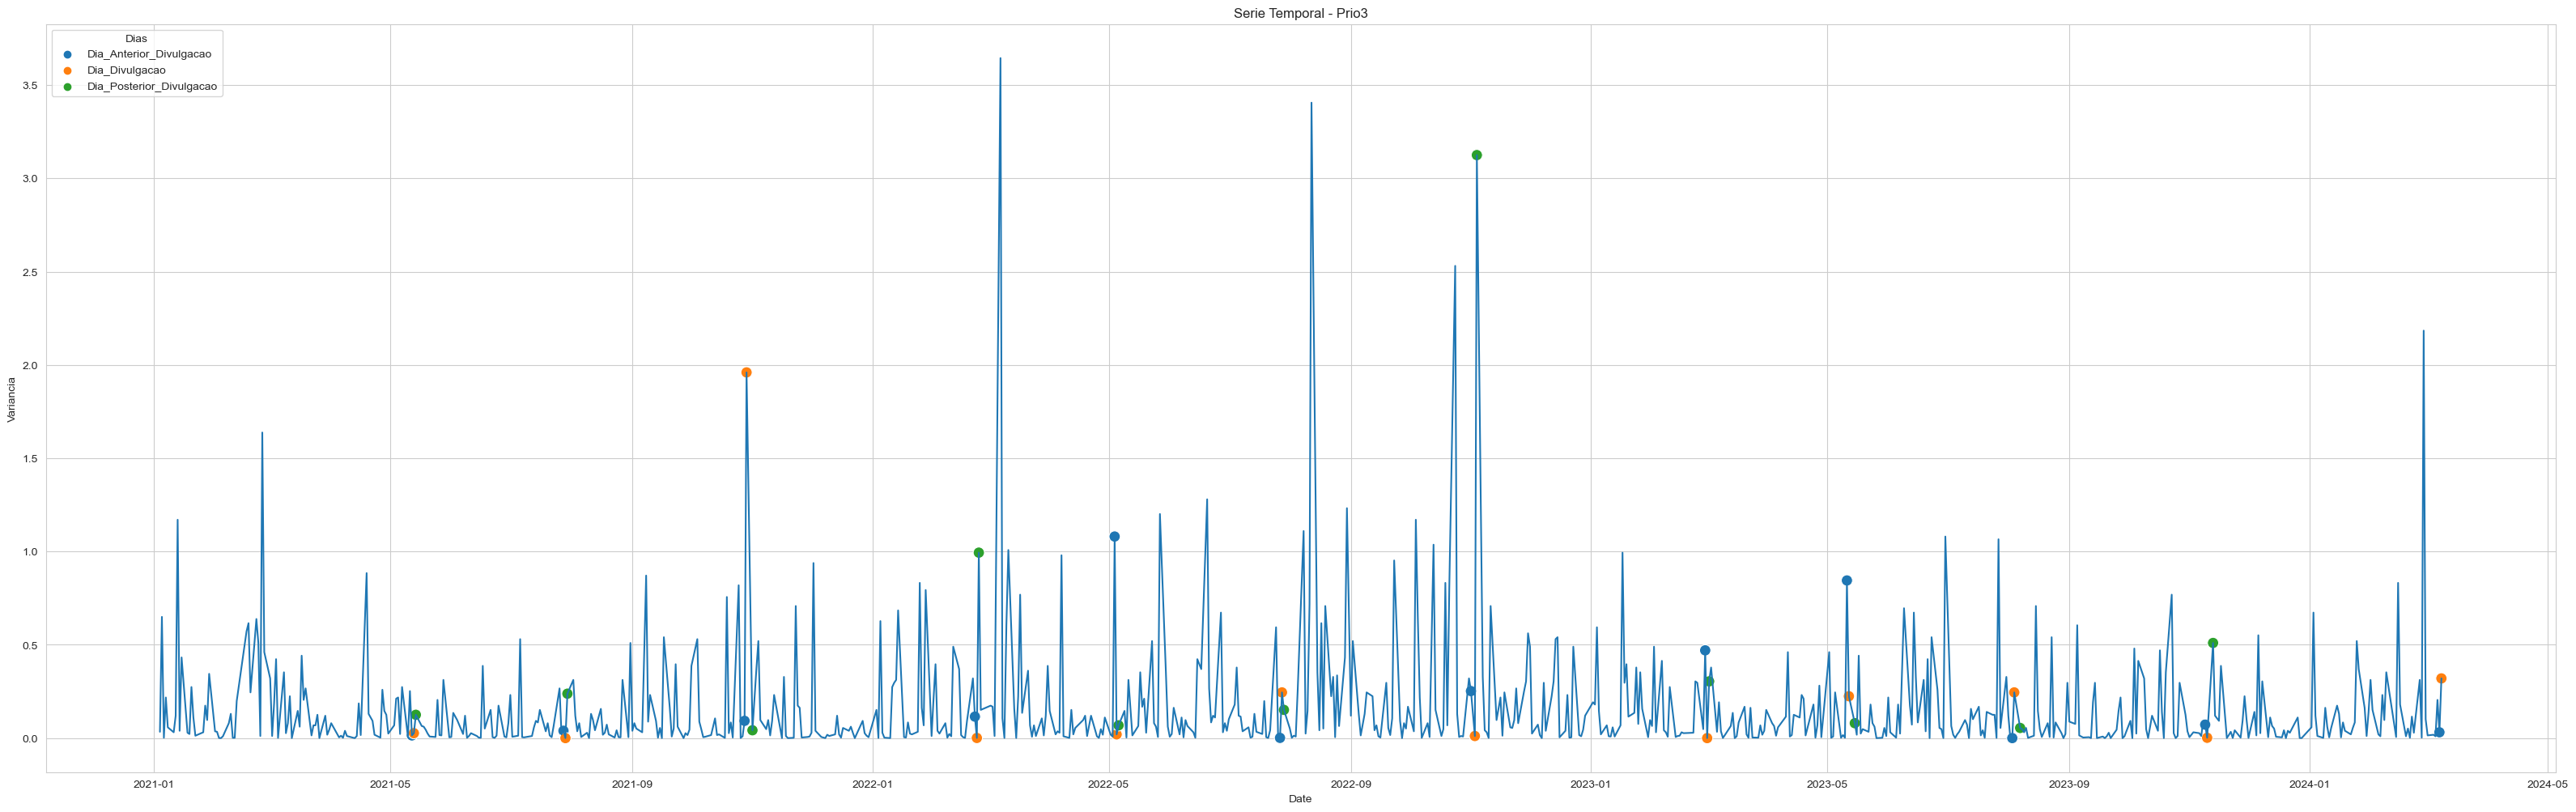

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=prio3.index, y='Variancia', data=prio3, palette='tab10')
sns.scatterplot(x=divulgacoes_prio3.index, y='Variancia', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Prio3')
plt.legend(title='Dias', loc='upper left')
plt.show()

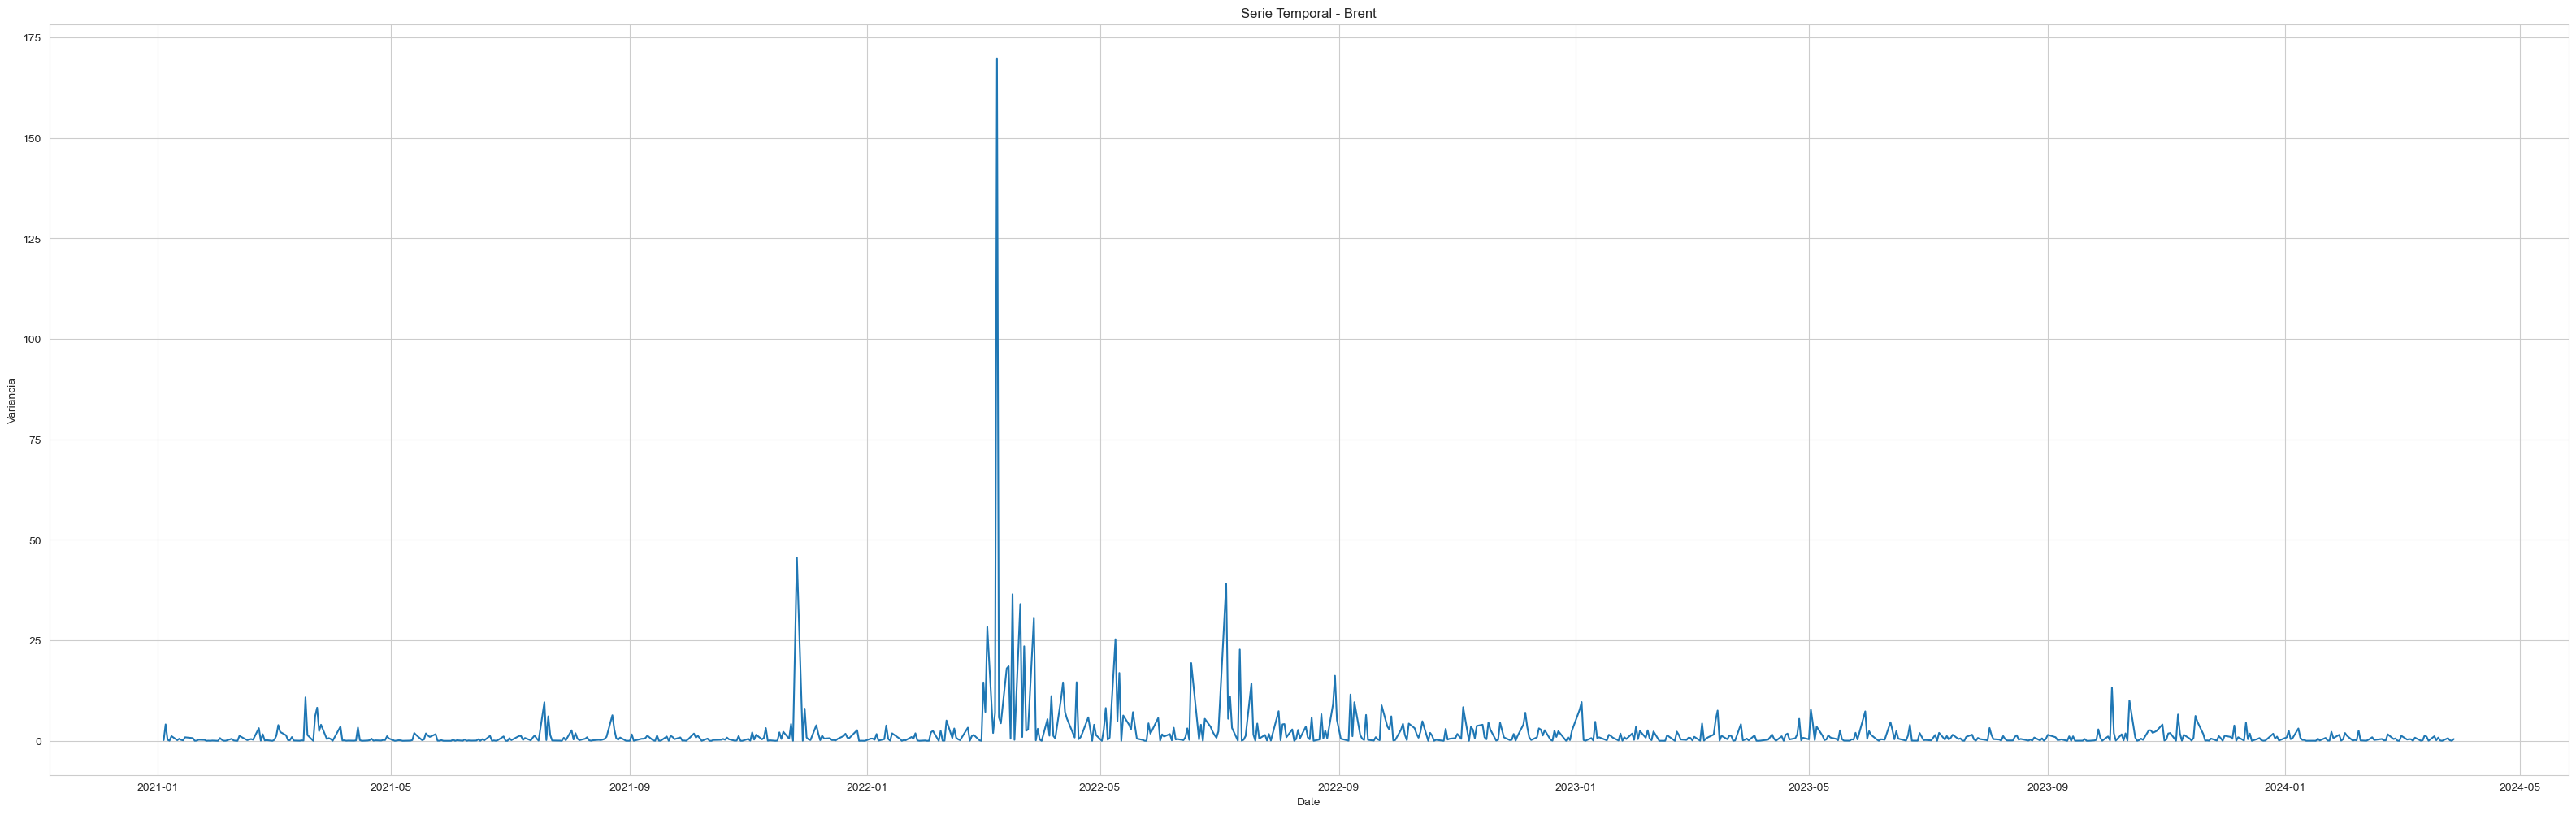

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=Brent.index, y='Variancia', data=Brent, palette='tab10')
plt.title('Serie Temporal - Brent')
plt.show()

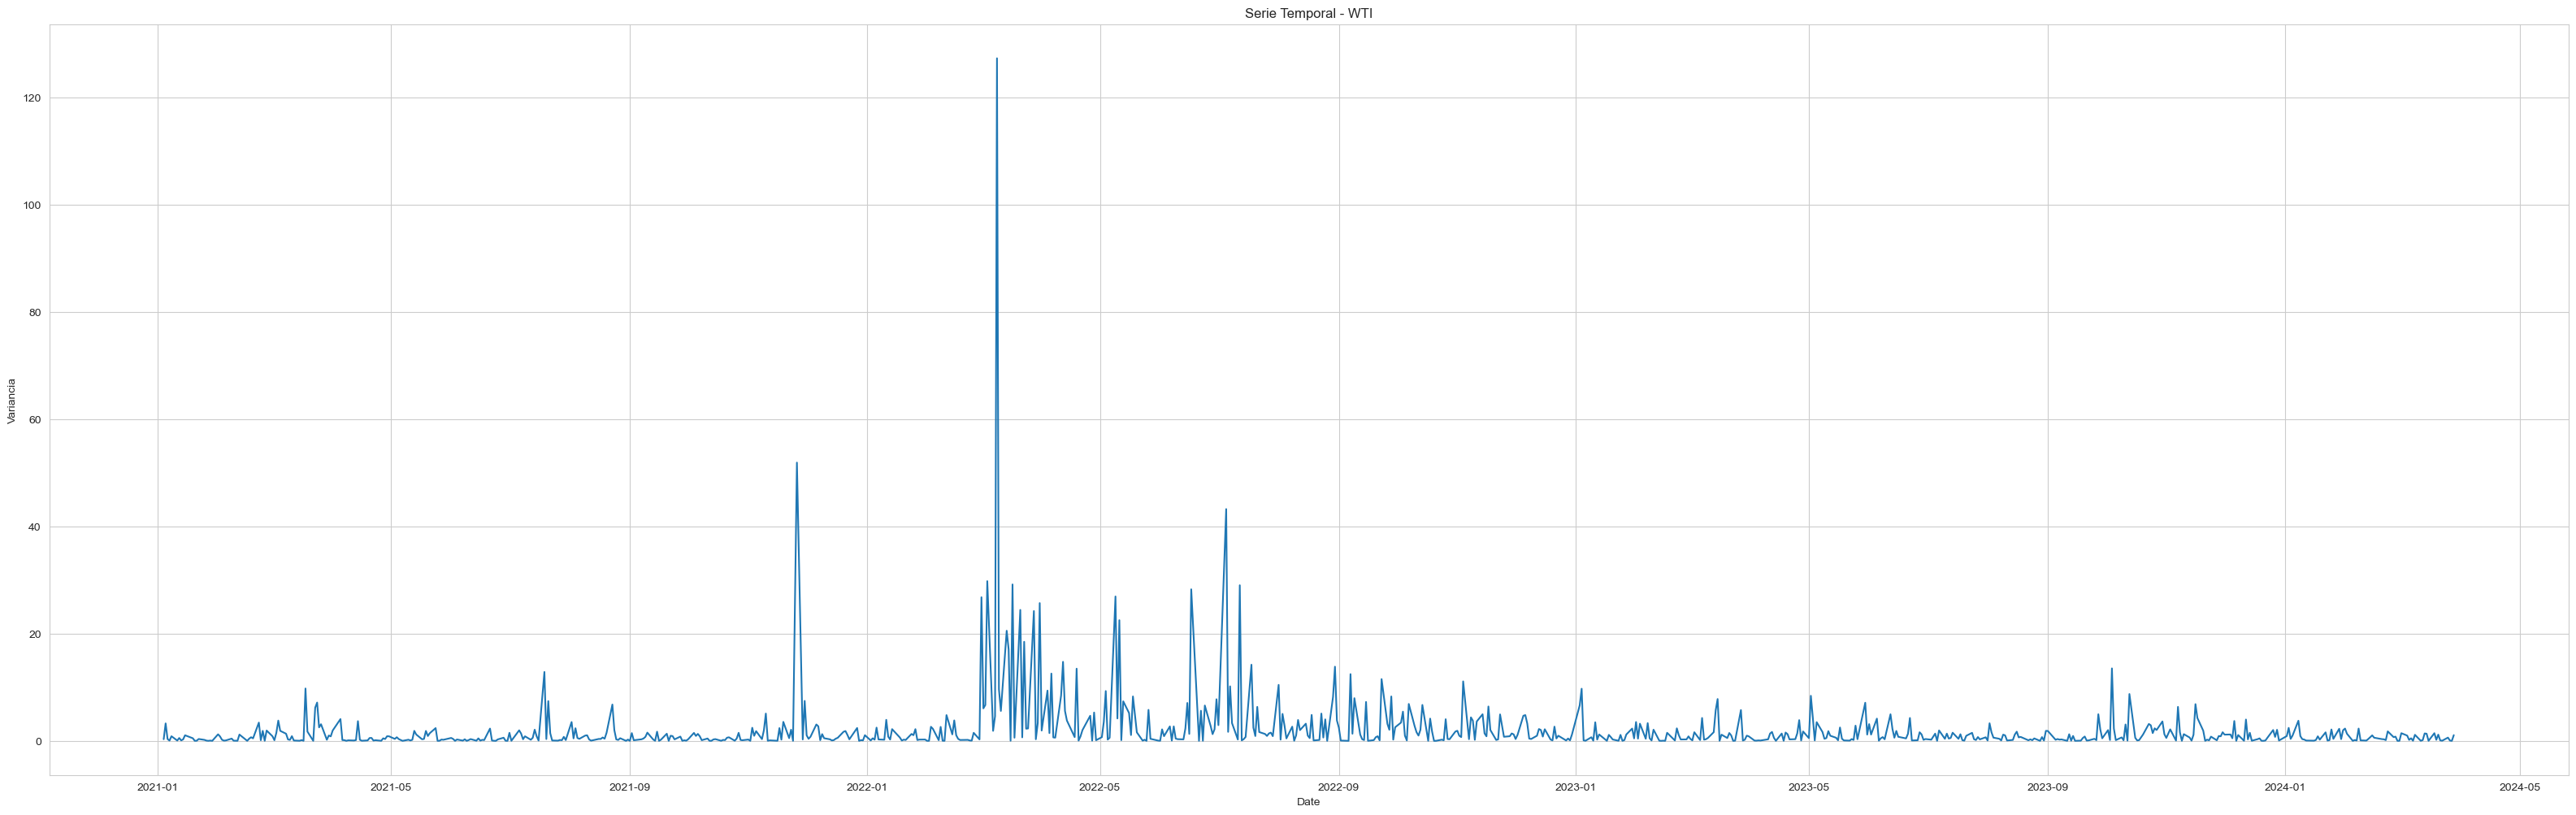

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=WTI.index, y='Variancia', data=WTI, palette='tab10')
plt.title('Serie Temporal - WTI')
plt.show()

## Retorno

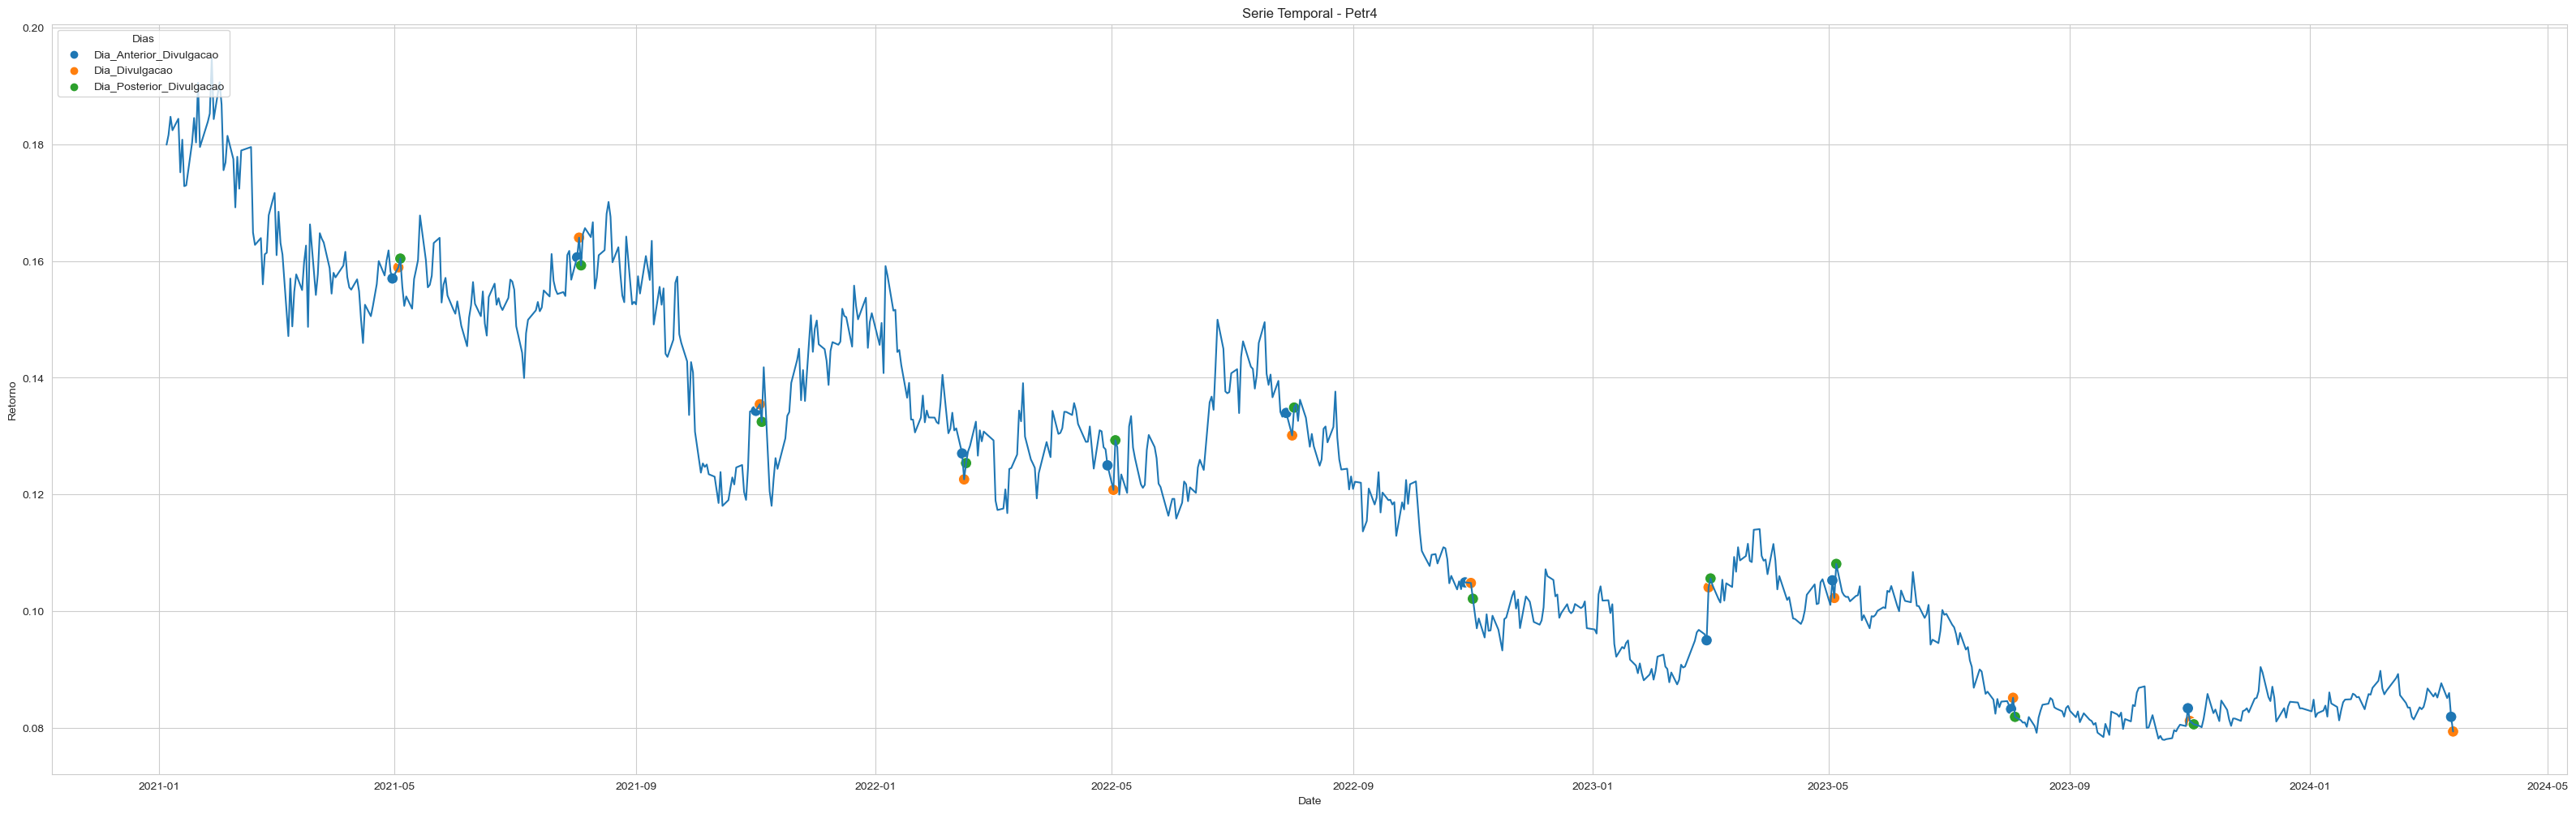

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=petr4.index, y='Retorno', data=petr4, palette='tab10')
sns.scatterplot(x=divulgacoes_petr4.index, y='Retorno', hue='Divulgacao', data=divulgacoes_petr4, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Petr4')
plt.legend(title='Dias', loc='upper left')
plt.show()

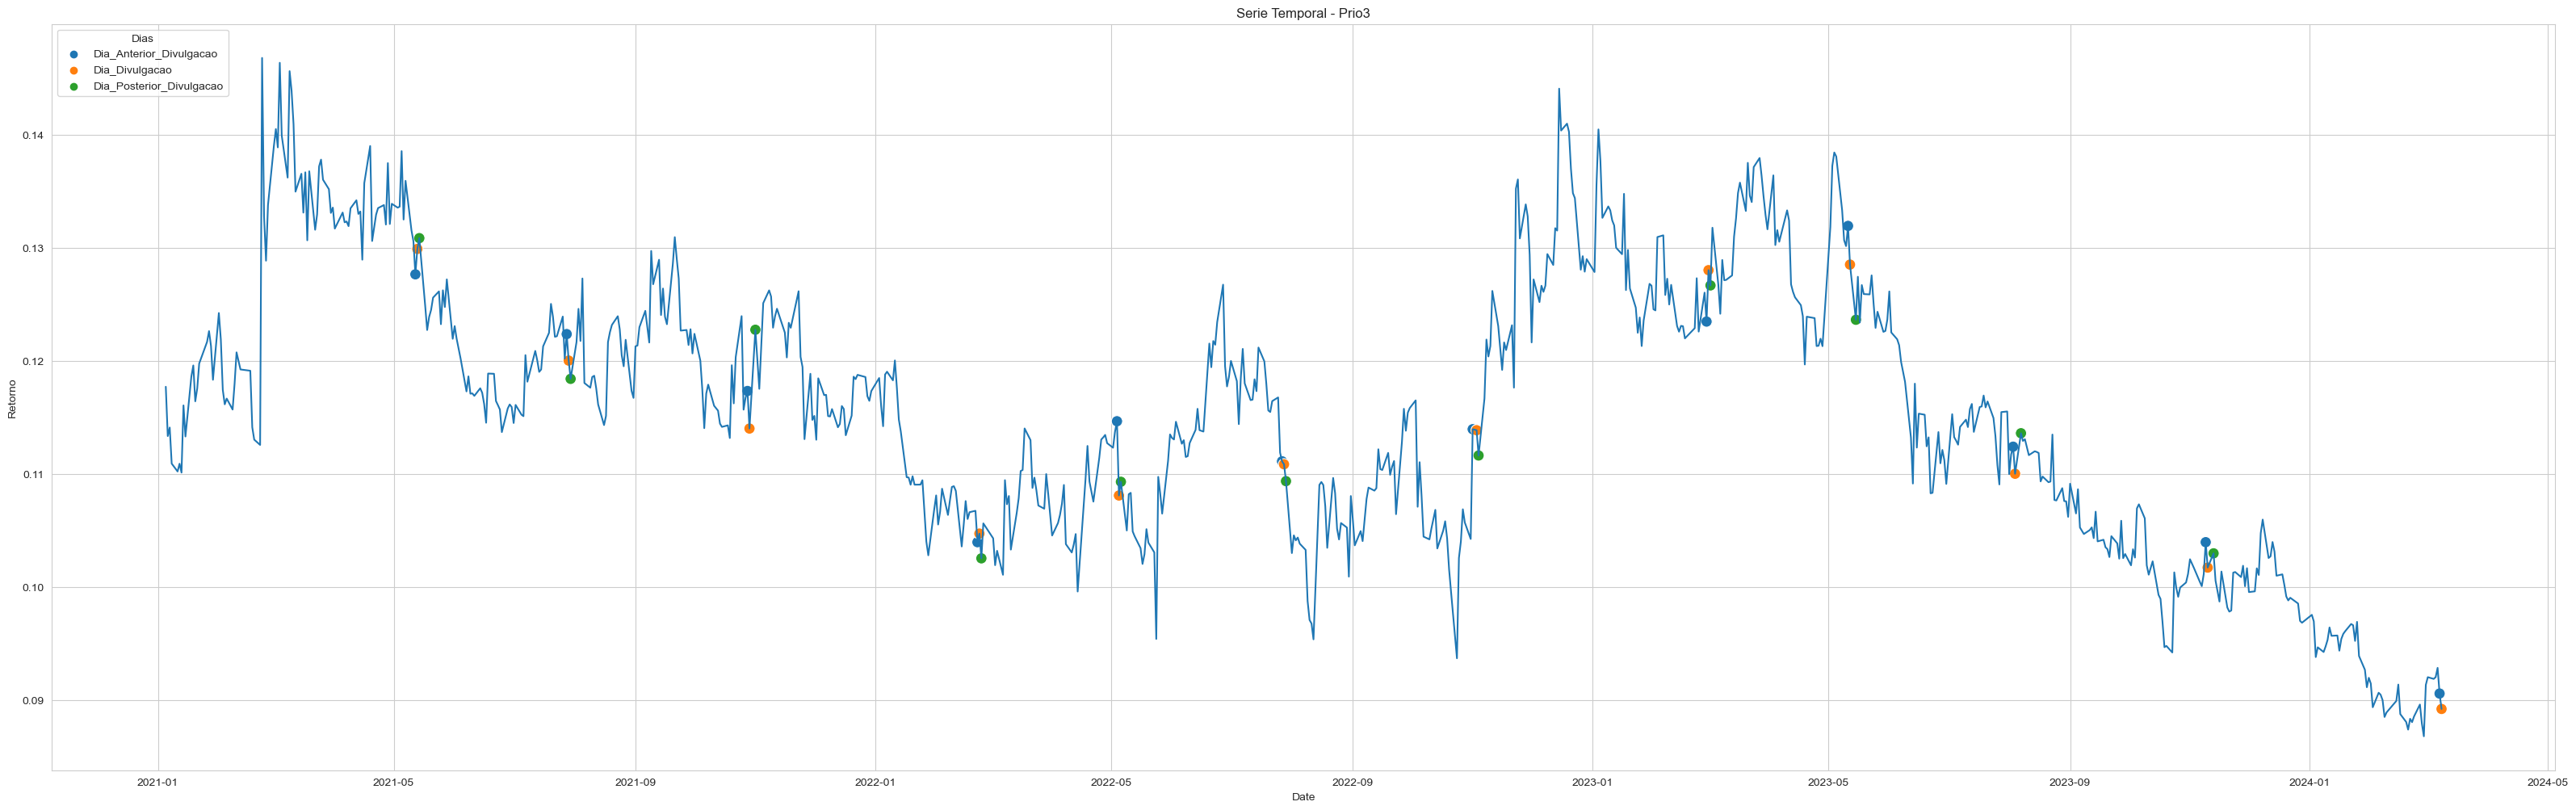

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=prio3.index, y='Retorno', data=prio3, palette='tab10')
sns.scatterplot(x=divulgacoes_prio3.index, y='Retorno', hue='Divulgacao', data=divulgacoes_prio3, marker='o', s=100, color='red', legend=True)
plt.title('Serie Temporal - Prio3')
plt.legend(title='Dias', loc='upper left')
plt.show()

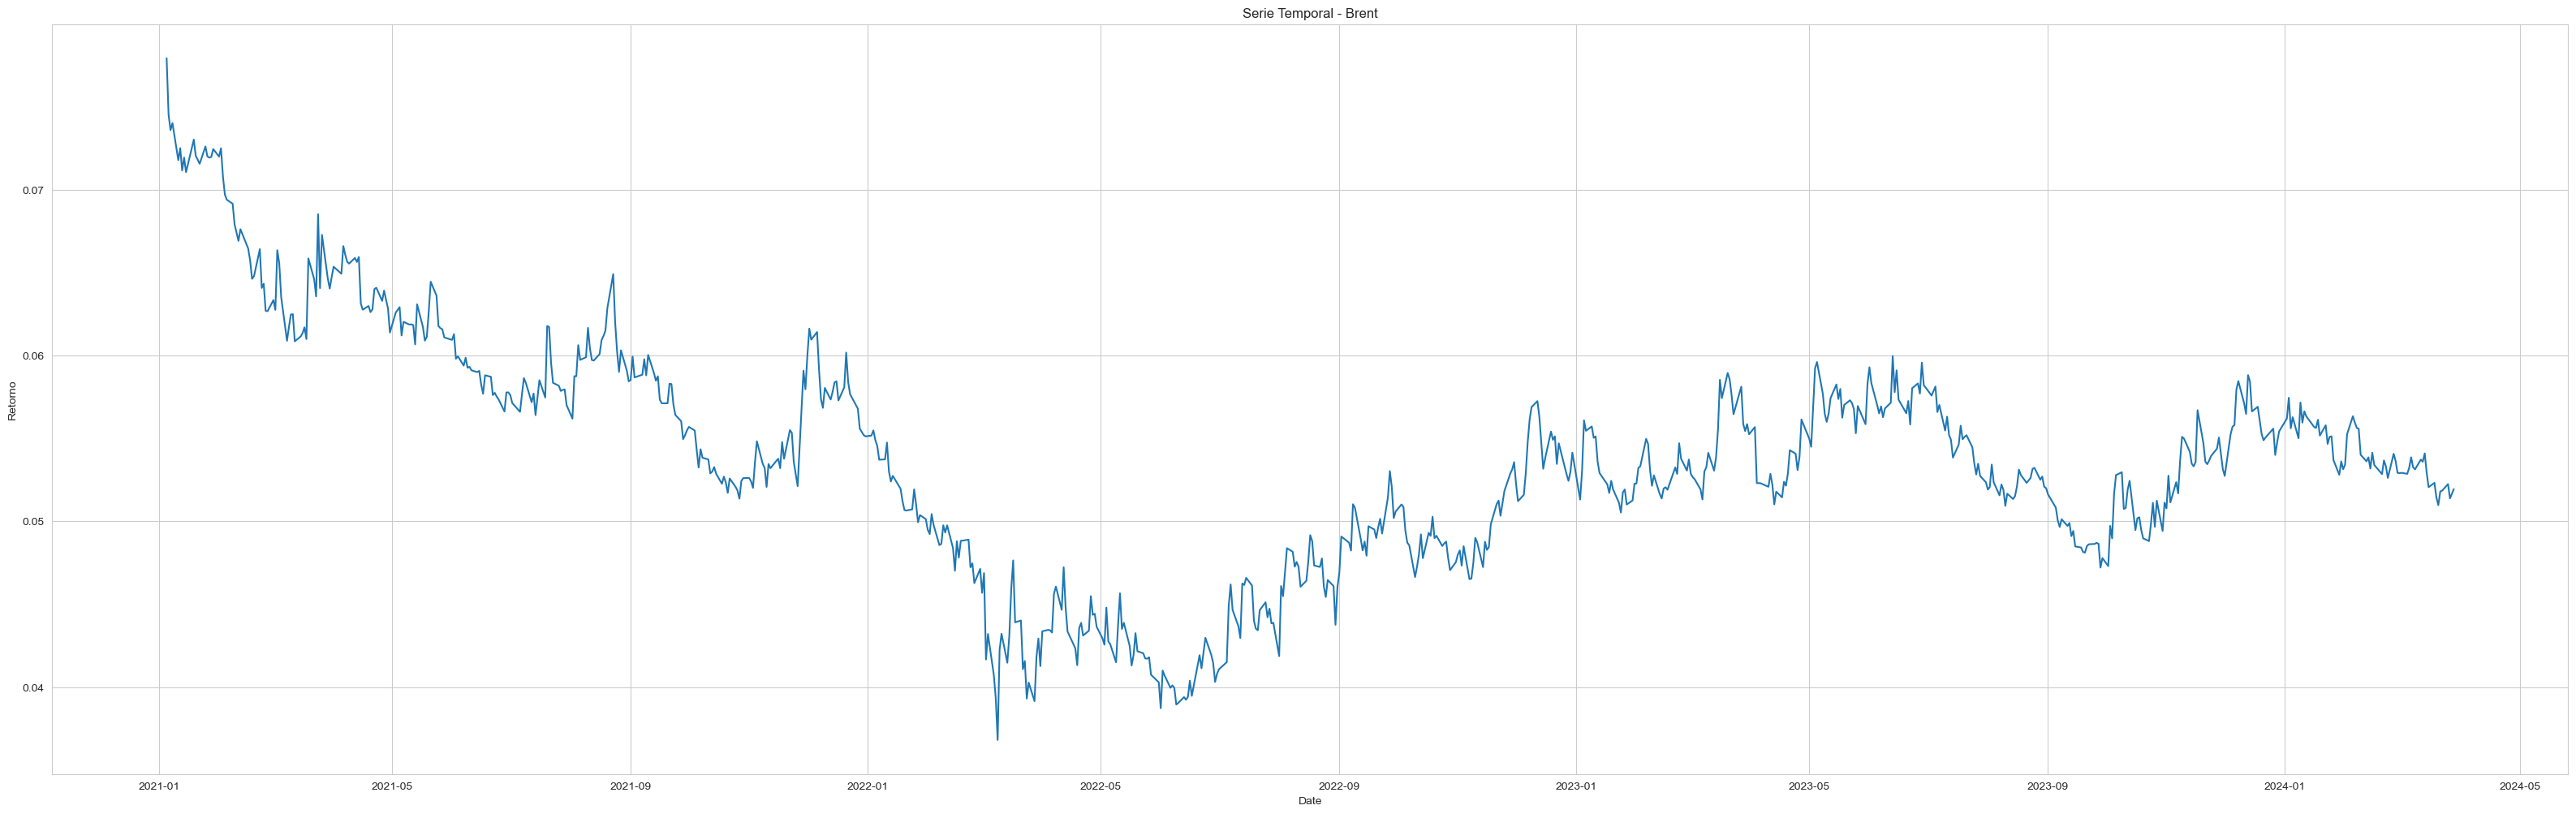

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=Brent.index, y='Retorno', data=Brent, palette='tab10')
plt.title('Serie Temporal - Brent')
plt.show()

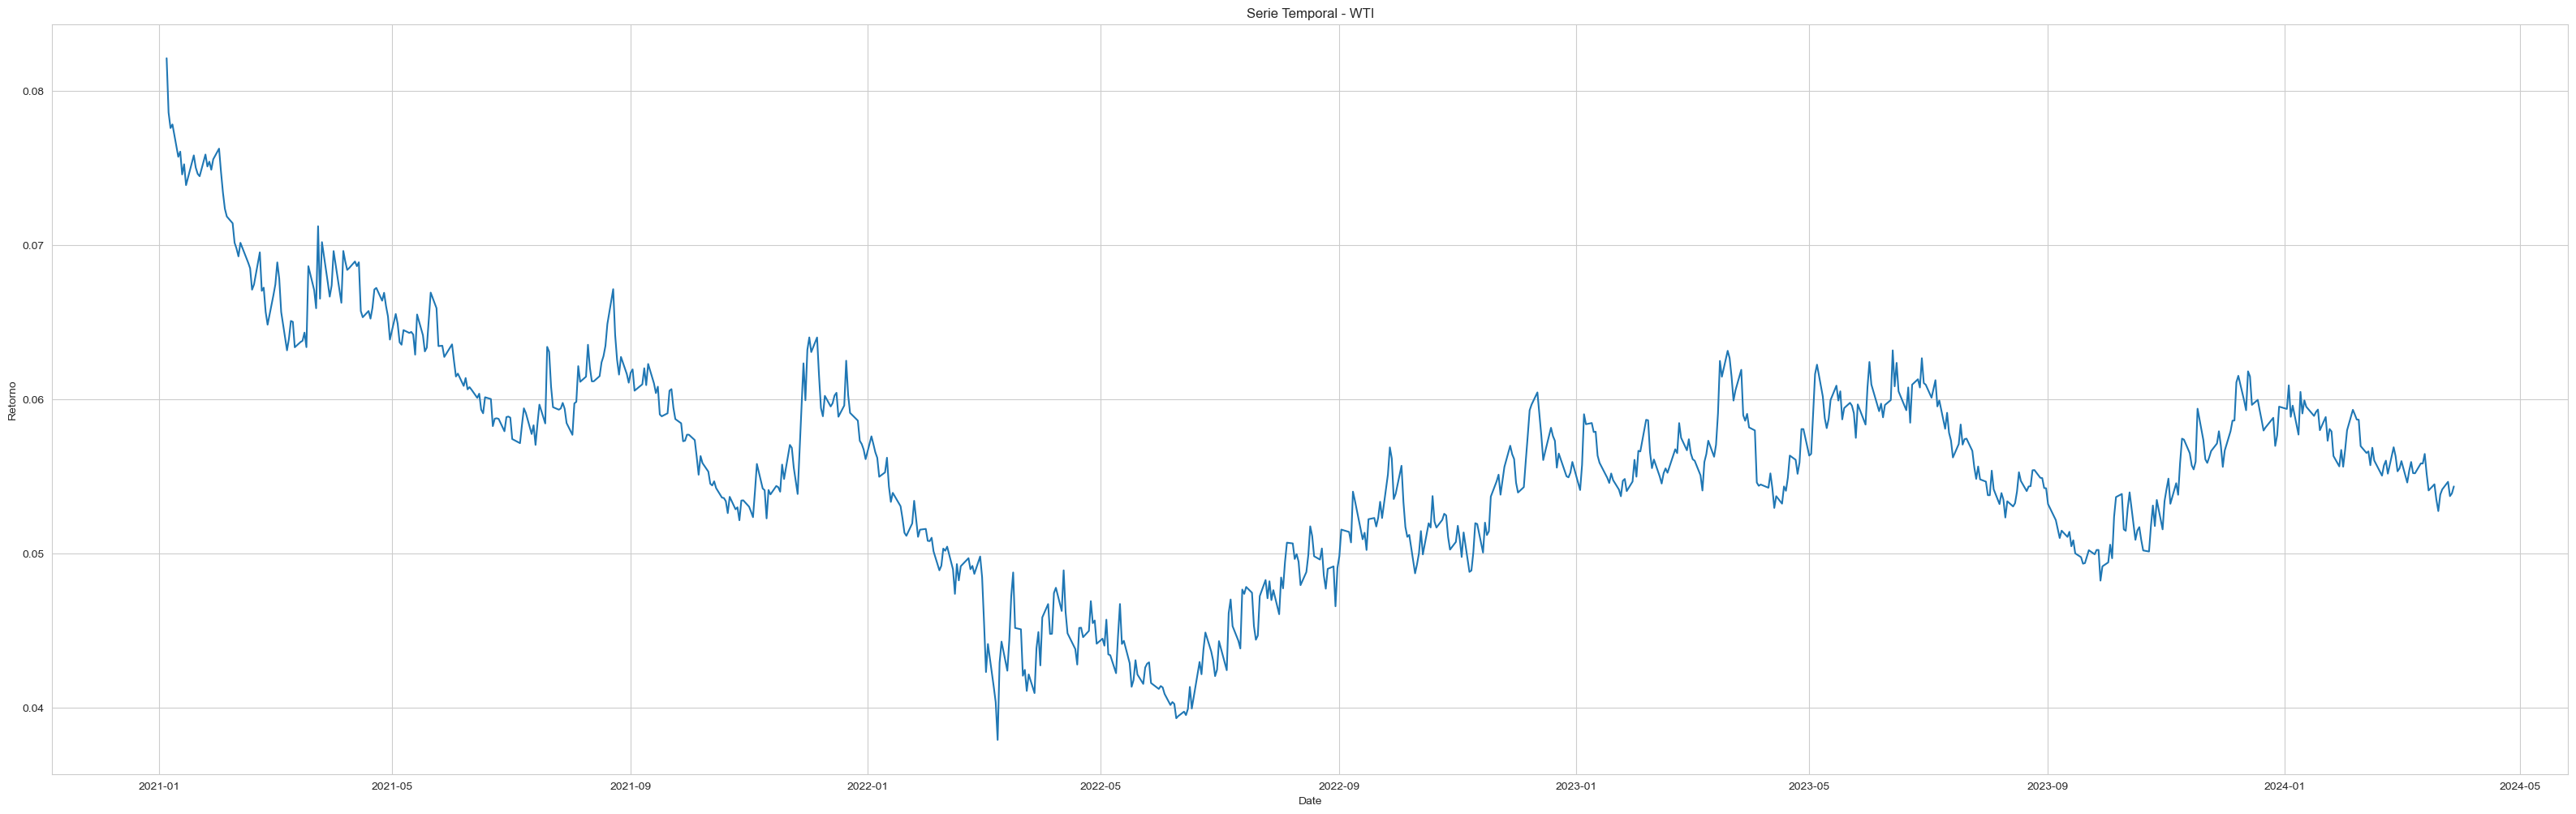

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(40, 12))
sns.lineplot(x=WTI.index, y='Retorno', data=WTI, palette='tab10')
plt.title('Serie Temporal - WTI')
plt.show()

Verificando análise gráfica é possível notar que as series de retorno aparentam não ser estacionárias, porém para que seja possível confirmar isso será realizado o teste de AD FUller, que testa as seguintes hipóteses:

Hipótese nula: a série possui raiz unitária**, ou seja, não estacionária.

Hipótese alternativa: série estacionária

Será adotado um nível de 5% para significância na análise.

** Uma série temporal com uma raiz unitária é como uma série que está "presa" a uma tendência, e não está "livre" para variar ou flutuar naturalmente. Isso significa que, mesmo que haja algumas variações de curto prazo, a série ainda está sendo puxada ou influenciada por algo constante ou de longo prazo.

Como resultado do teste será obtido o Pvalor, que caso seja maior que 5% indica que é viável acatar a hipótese nula de que a serie não é estacionária. Já caso seja menor que 5% deve-se acatar a hipotese alternativa de que a serie é estacionária. 

## Testes de Estacionaridade e AutoCorrelação

### PETR4

In [43]:
Pvalor_Petr4 = adfuller(petr4['Retorno'].dropna())[1]

if Pvalor_Petr4 <= 0.05:
    print('Deve-se rejeitar H0 (Estacionária)')
else:
    print('Deve-se acatar H0 (Não estacionária)')


Deve-se acatar H0 (Não estacionária)
